This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

In [1]:
from components.gptmodel import GPTModel_v2

In [2]:
import lightning as L

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 30002,
    "context_length": 256,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": True
}

In [4]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [5]:
from components.data import create_dataloader_v3

In [6]:
trainer_config = {
    "dataset_scale": 30,
    "batch_size": 64,
    "epochs": 1
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [7]:
def create_dataloader(text, train=True):
    return create_dataloader_v3(
        text,
        batch_size=trainer_config["batch_size"],
        max_length=GPT_CONFIG_124M["context_length"],
        stride=GPT_CONFIG_124M["context_length"],
        drop_last=train,
        shuffle=train,
        num_workers=23
    )

In [8]:
%%time

train_file = "../data/TinyStories/TinyStoriesV2-GPT4-train.txt"
with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read()

train_len = len(train_text)
train_text = train_text[:train_len // trainer_config["dataset_scale"]]
train_loader = create_dataloader(train_text)

CPU times: user 11.7 s, sys: 3.6 s, total: 15.3 s
Wall time: 15.9 s


In [9]:
val_file = "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt"
with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read()

val_loader = create_dataloader(val_text, train=False)

In [10]:
from torch.optim.lr_scheduler import OneCycleLR

class LitGPTModel(L.LightningModule):
    def __init__(self, GPTModel, total_steps, max_lr=1e-3):
        super().__init__()
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.model = GPTModel

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1
        x, y = batch
        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch

        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.max_lr, weight_decay=0.1
        )
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100)

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.max_lr,
            total_steps=self.total_steps,
            pct_start=0.1,  # 10% warmup
            anneal_strategy='cos'
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

In [11]:
model = GPTModel_v2(GPT_CONFIG_124M)
litmodel = LitGPTModel(model, 1 + trainer_config["epochs"]*len(train_loader)//trainer_config["grad_batches"])

In [12]:
%%time

trainer = L.Trainer(max_epochs=trainer_config["epochs"], enable_progress_bar=True, accumulate_grad_batches=trainer_config["grad_batches"])
trainer.fit(model=litmodel, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-03-31 11:49:08.466019: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 11:49:08.475654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743446948.488565    4094 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743446948.492372    4094 cuda_blas.cc:1407] Unable to regis

Epoch 0: 100%|██████████████████████| 1413/1413 [02:06<00:00, 11.21it/s, v_num=17, accuracy_step=0.554, loss_step=2.120]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████████████████████████████████████████| 432/432 [00:13<00:00, 31.22it/s]
Epoch 0: 100%|█| 1413/1413 [02:20<00:00, 10.08it/s, v_num=17, accuracy_step=0.554, loss_step=2.120, val_accuracy_step=0.

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|█| 1413/1413 [02:20<00:00, 10.03it/s, v_num=17, accuracy_step=0.554, loss_step=2.120, val_accuracy_step=0.
CPU times: user 2min 19s, sys: 4.5 s, total: 2min 24s
Wall time: 2min 24s


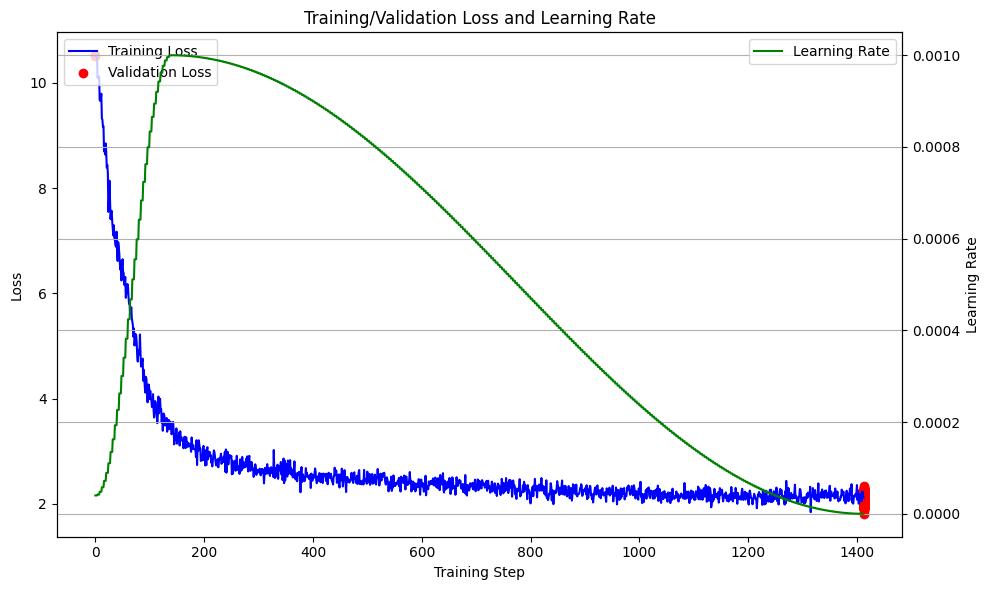

In [15]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

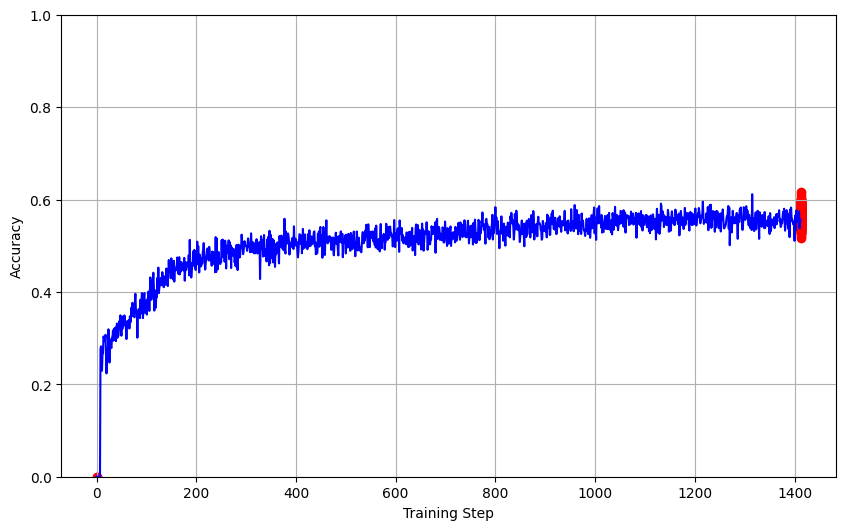

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()